# Learning Exercise II-A

Let's try to solve a "Lights Out" puzzle using a quantum computer! The information you learned last week will be helpful in solving this puzzle.

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure only the `solution` (9bit) that solves the puzzle. **In addition, please implement the quantum circuit within 28 qubits.**

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

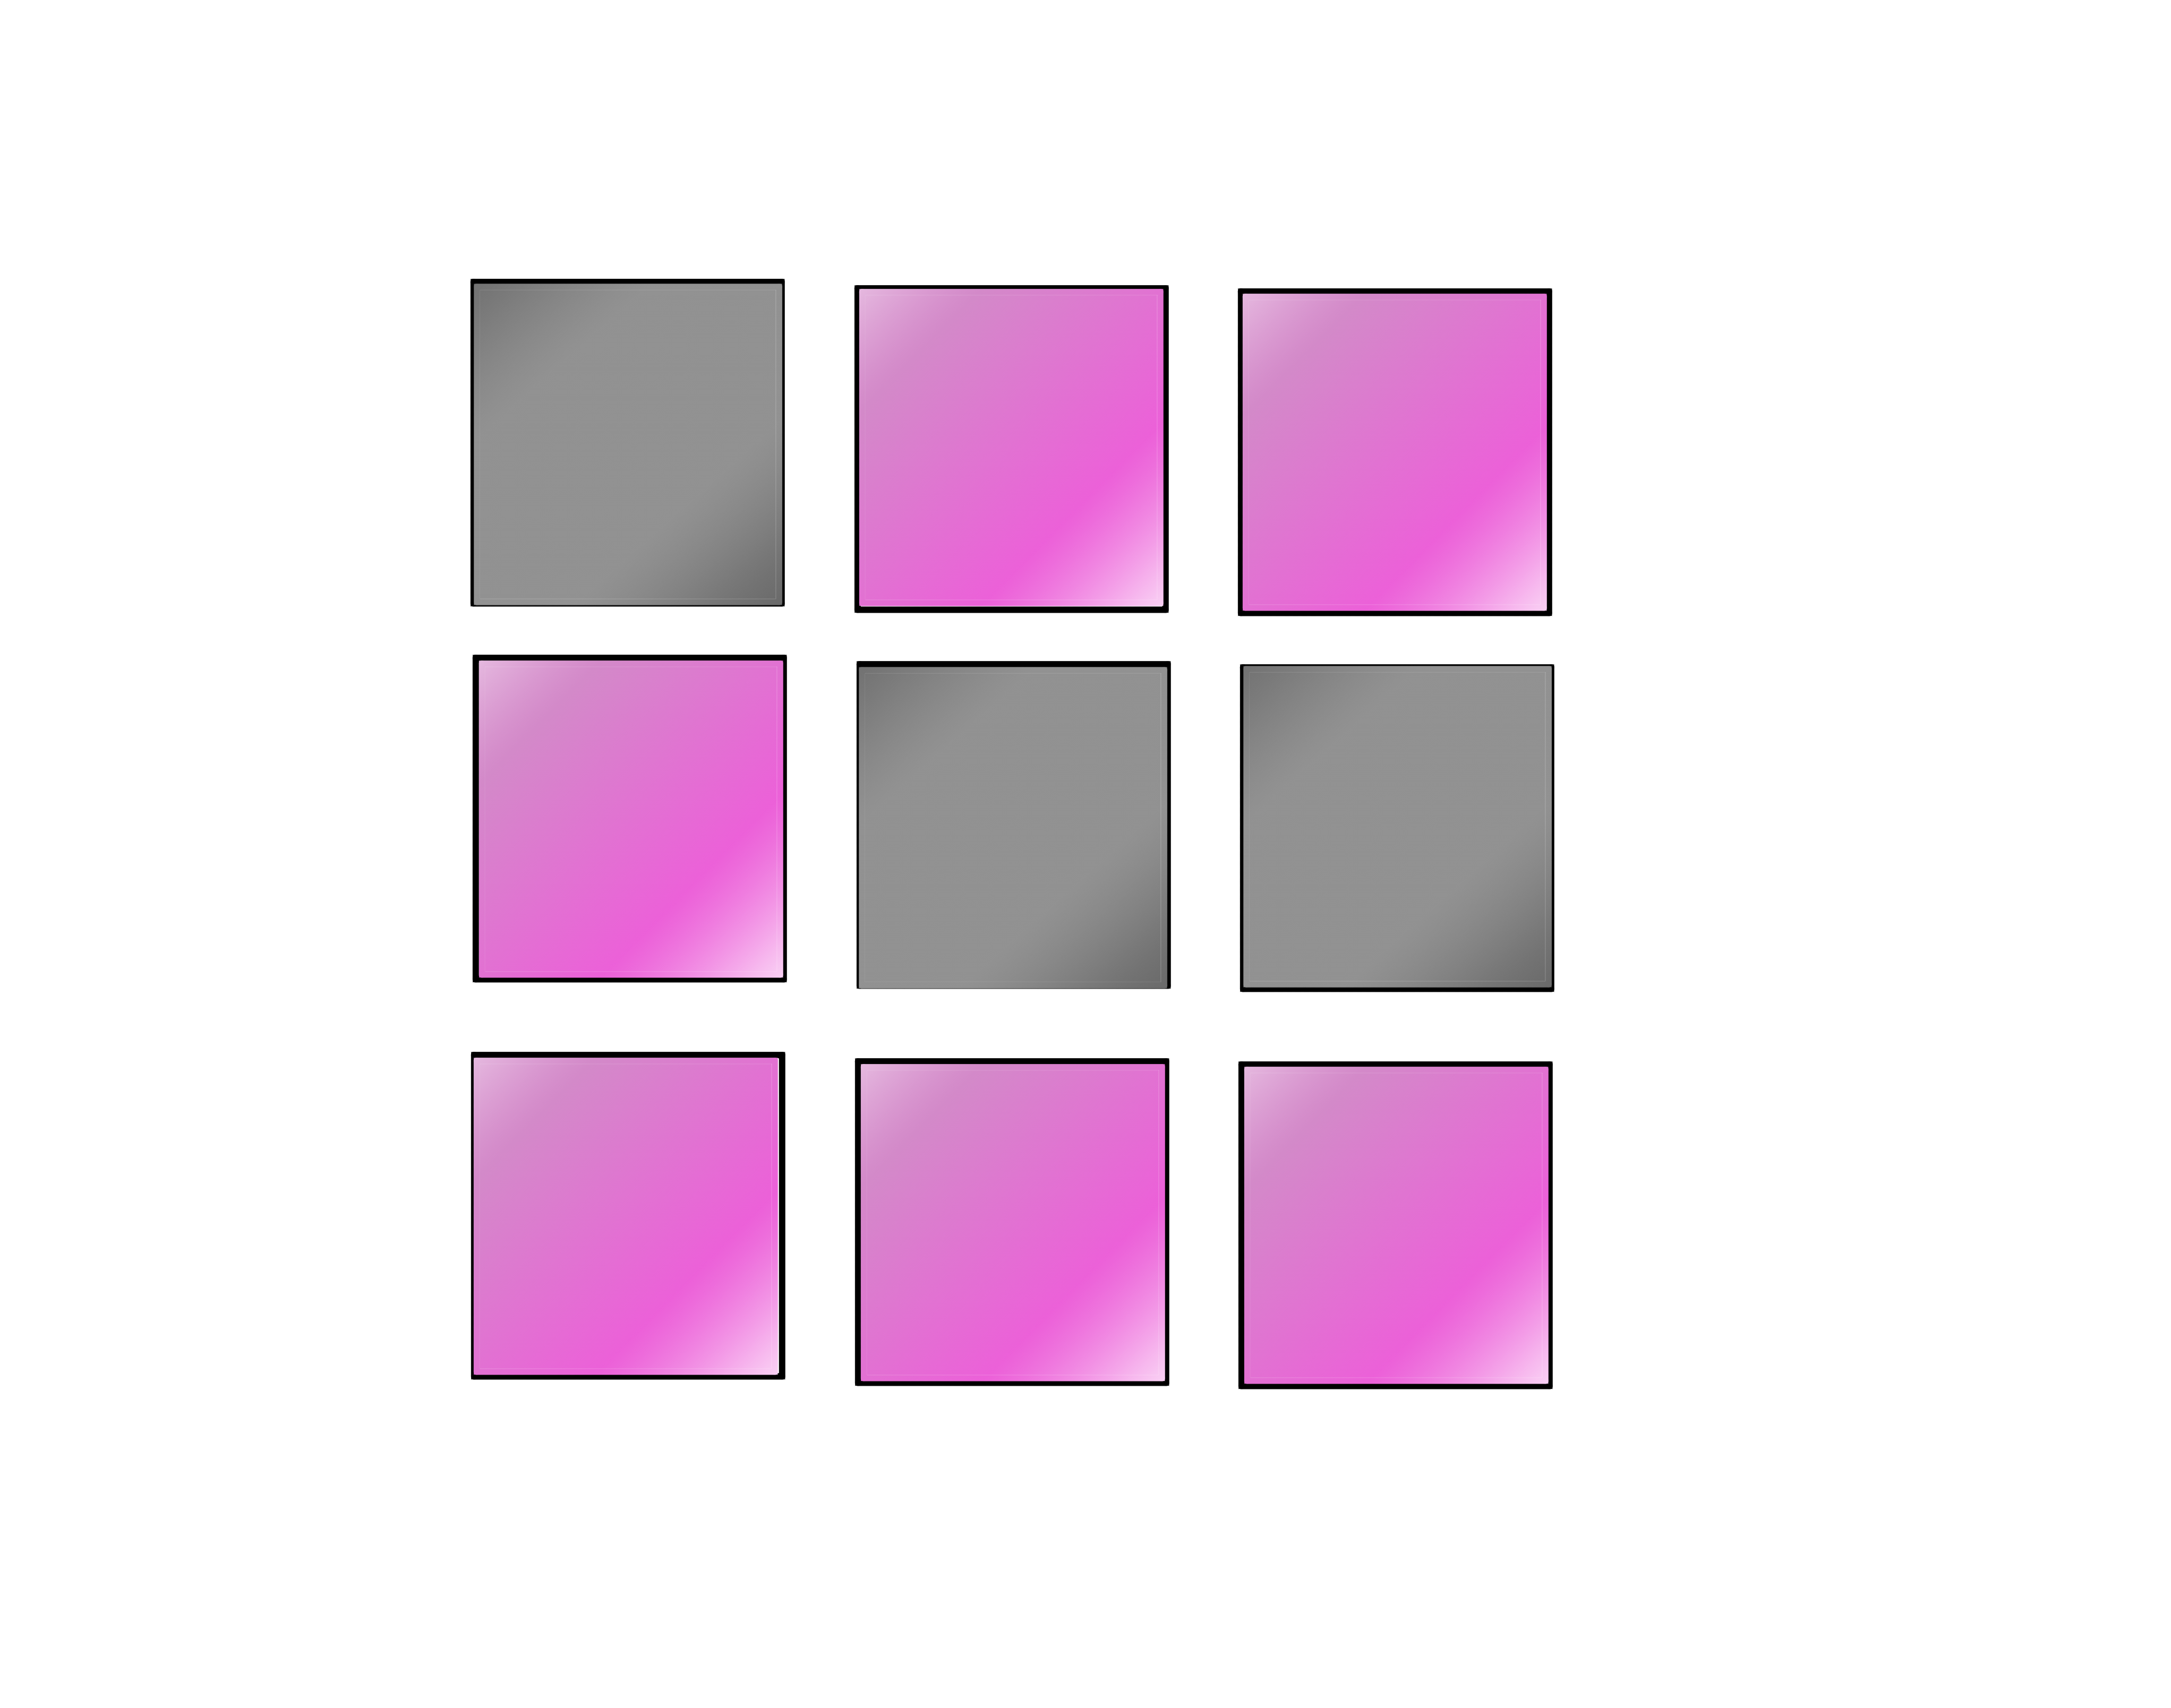

In [1]:
from IPython.display import Image, display
Image('lights_out_prob.png')

## Simple answer: Traverse the solution with Grover's algorithm
The hint shows that the answer can be expressed as a binary vector. Therefore, solution candidates can be expressed by 9-bit binary vectors, so let's express them by superposition and search for the solution by Grover's algorithm.

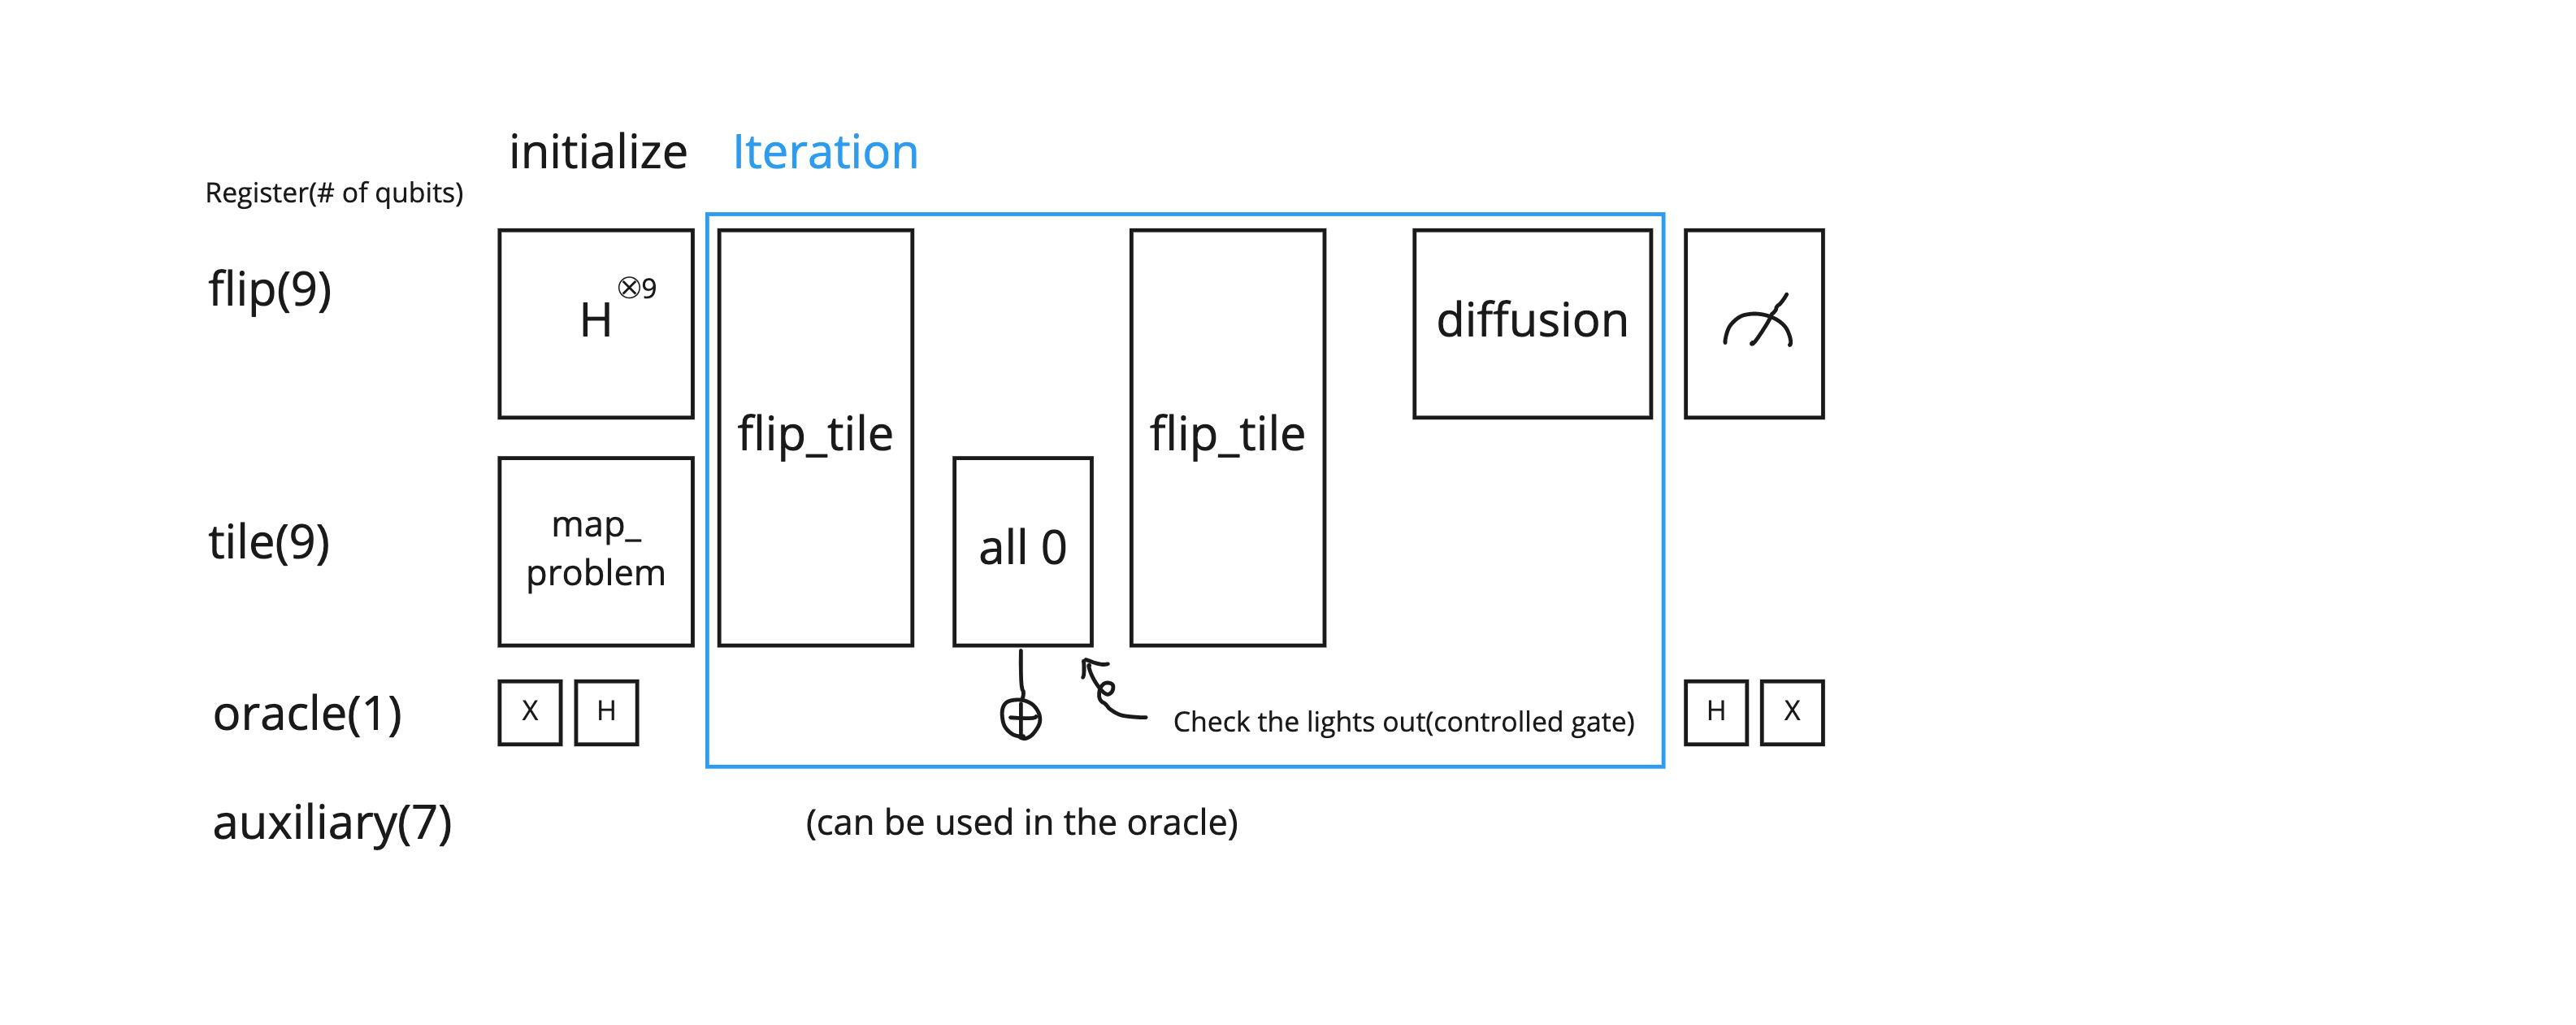

In [2]:
Image('lights_out_circuit.jpg')

Import Qiskit and prepare the registers. The `tile` register is used to represent the state of the lights. The `flip` register represents which switch to press. The `oracle` register is used to mark the solution that can turned off all lights. The `auxiliary` register is used to reduce the cost of mct gates (the problem can be solved without this register). The `result` register is a classic register for storing the answer to a question.

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
tile = QuantumRegister(9)
flip = QuantumRegister(9)
oracle = QuantumRegister(1)
auxiliary = QuantumRegister(7)
result = ClassicalRegister(9)
#26 qubit
qc = QuantumCircuit(tile, flip, oracle, auxiliary, result)

First, prepare the binary vector of the question.

In [4]:
lights = [0, 1, 1, 1, 0, 0, 1, 1, 1]

Prepare a function that maps the binary vector(`lights`) in question to the quantum register(`tile`).

In [5]:
def map_board(lights, qc, qr):
    j = 0
    for i in lights:
        if i==1:
            qc.x(qr[j])
            j+=1
        else:
            j+=1

Before we run the Grover algorithm oracle, we need to make some preparations.
1. map_board
2. Create superposition in the `flip` register. This represents candidates of solution.
3. Initializes the qubit that stores the oracle(which mark the solution that turns everything off) result in phase

In [6]:
def initialize():
    map_board(lights, qc, tile)

    qc.h(flip[0:10])
    qc.x(oracle[0])
    qc.h(oracle[0])

Implements the function which change the board state(in `tile`) based on the solution candidates(in `flip`)

In [7]:
# Subroutine for oracle
# Calculate what the light state will be after pressing each solution candidate. 
def flip_tile(qc,flip,tile):
    qc.cx(flip[0], tile[0])
    qc.cx(flip[0], tile[1])
    qc.cx(flip[0], tile[3])
    qc.cx(flip[1], tile[0])
    qc.cx(flip[1], tile[1])
    qc.cx(flip[1], tile[2])
    qc.cx(flip[1], tile[4])
    qc.cx(flip[2], tile[1])
    qc.cx(flip[2], tile[2])
    qc.cx(flip[2], tile[5])
    qc.cx(flip[3], tile[0])
    qc.cx(flip[3], tile[3])
    qc.cx(flip[3], tile[4])
    qc.cx(flip[3], tile[6])
    qc.cx(flip[4], tile[1])
    qc.cx(flip[4], tile[3])
    qc.cx(flip[4], tile[4])
    qc.cx(flip[4], tile[5])
    qc.cx(flip[4], tile[7])
    qc.cx(flip[5], tile[2])
    qc.cx(flip[5], tile[4])
    qc.cx(flip[5], tile[5])
    qc.cx(flip[5], tile[8])
    qc.cx(flip[6], tile[3])
    qc.cx(flip[6], tile[6])
    qc.cx(flip[6], tile[7])
    qc.cx(flip[7], tile[4])
    qc.cx(flip[7], tile[6])
    qc.cx(flip[7], tile[7])
    qc.cx(flip[7], tile[8])
    qc.cx(flip[8], tile[5])
    qc.cx(flip[8], tile[7])
    qc.cx(flip[8], tile[8])

Since the solution space is $2^9$, the iteration is about $\frac{\pi}{4} \sqrt{2^9} - \frac{1}{2} \risingdotseq 17.271$, so try it $17$ times. 

For more details about the number of iteration, please see the [Hint from Dr.Ryoko](REPLACE_HERE) for week 1-B.

In [8]:
initialize()

for i in range(17):
    # oracle
    flip_tile(qc,flip,tile)
    
    qc.x(tile[0:9])
    qc.mct(tile[0:9], oracle[0], auxiliary[0:7], mode='basic')
    qc.x(tile[0:9])
    
    flip_tile(qc,flip,tile)
    
    # diffusion
    qc.h(flip)
    qc.x(flip)
    qc.h(flip[8])
    qc.mct(flip[0:8], flip[8], auxiliary[0:7], mode='basic')
    qc.h(flip[8])
    qc.x(flip)
    qc.h(flip)

# Uncompute
qc.h(oracle[0])
qc.x(oracle[0])
# Measuremnt
qc.measure(flip,result)

# Make the Out put order the same as the input.
qc = qc.reverse_bits() 

In [9]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroll the circuit
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)

# obtain gates
gates=new_circuit.count_ops()
print(gates)

OrderedDict([('u3', 3929), ('cx', 2652), ('measure', 9)])


The cost of the circuit is 30449.

In [10]:
%%time
from qiskit import IBMQ, execute
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()

/Users/parton/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


CPU times: user 629 ms, sys: 27.3 ms, total: 657 ms
Wall time: 1min 11s


In [11]:
score_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
final_score = score_sorted[0:40]
final_score

[('110010101', 7998), ('100010101', 1), ('110010000', 1)]

The answer is 110010101!

### Another solution

When the value of top row(3 bits) of the answer is fixed, the lights the player should push(left 6 bits) is uniquely determined(or cannot be solved with that top row value). This fact can be found with the property: 

* After applying the n-th row of the solution candidate, if there is something that remains lit on the n-th line, it must be turned off on the n+1th line (so the solution on the n+1th line is fixed). 

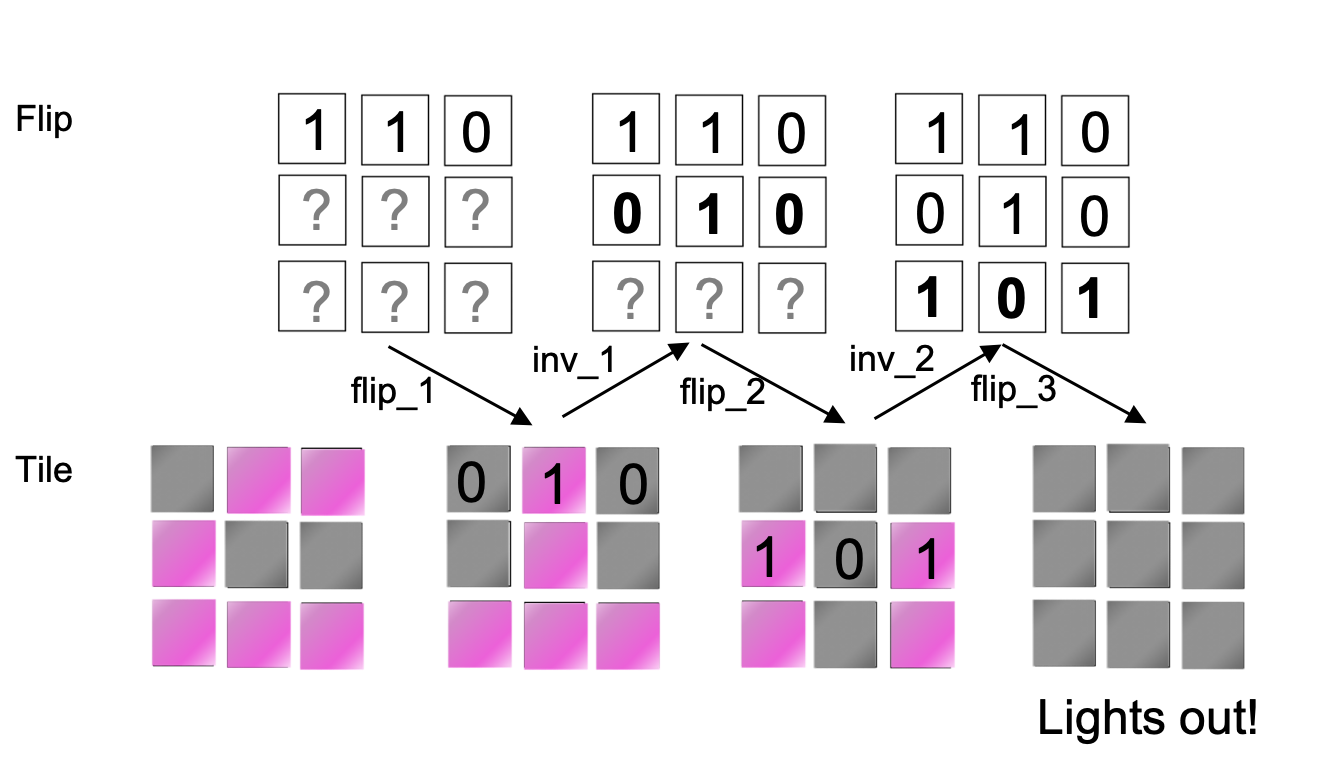

In [12]:
Image('lights_out_optimal.png')

With this method, the search space can be suppressed to $2^3$ (then the iteration can be reduced). Prepare only the top 3 qubit as a superposition

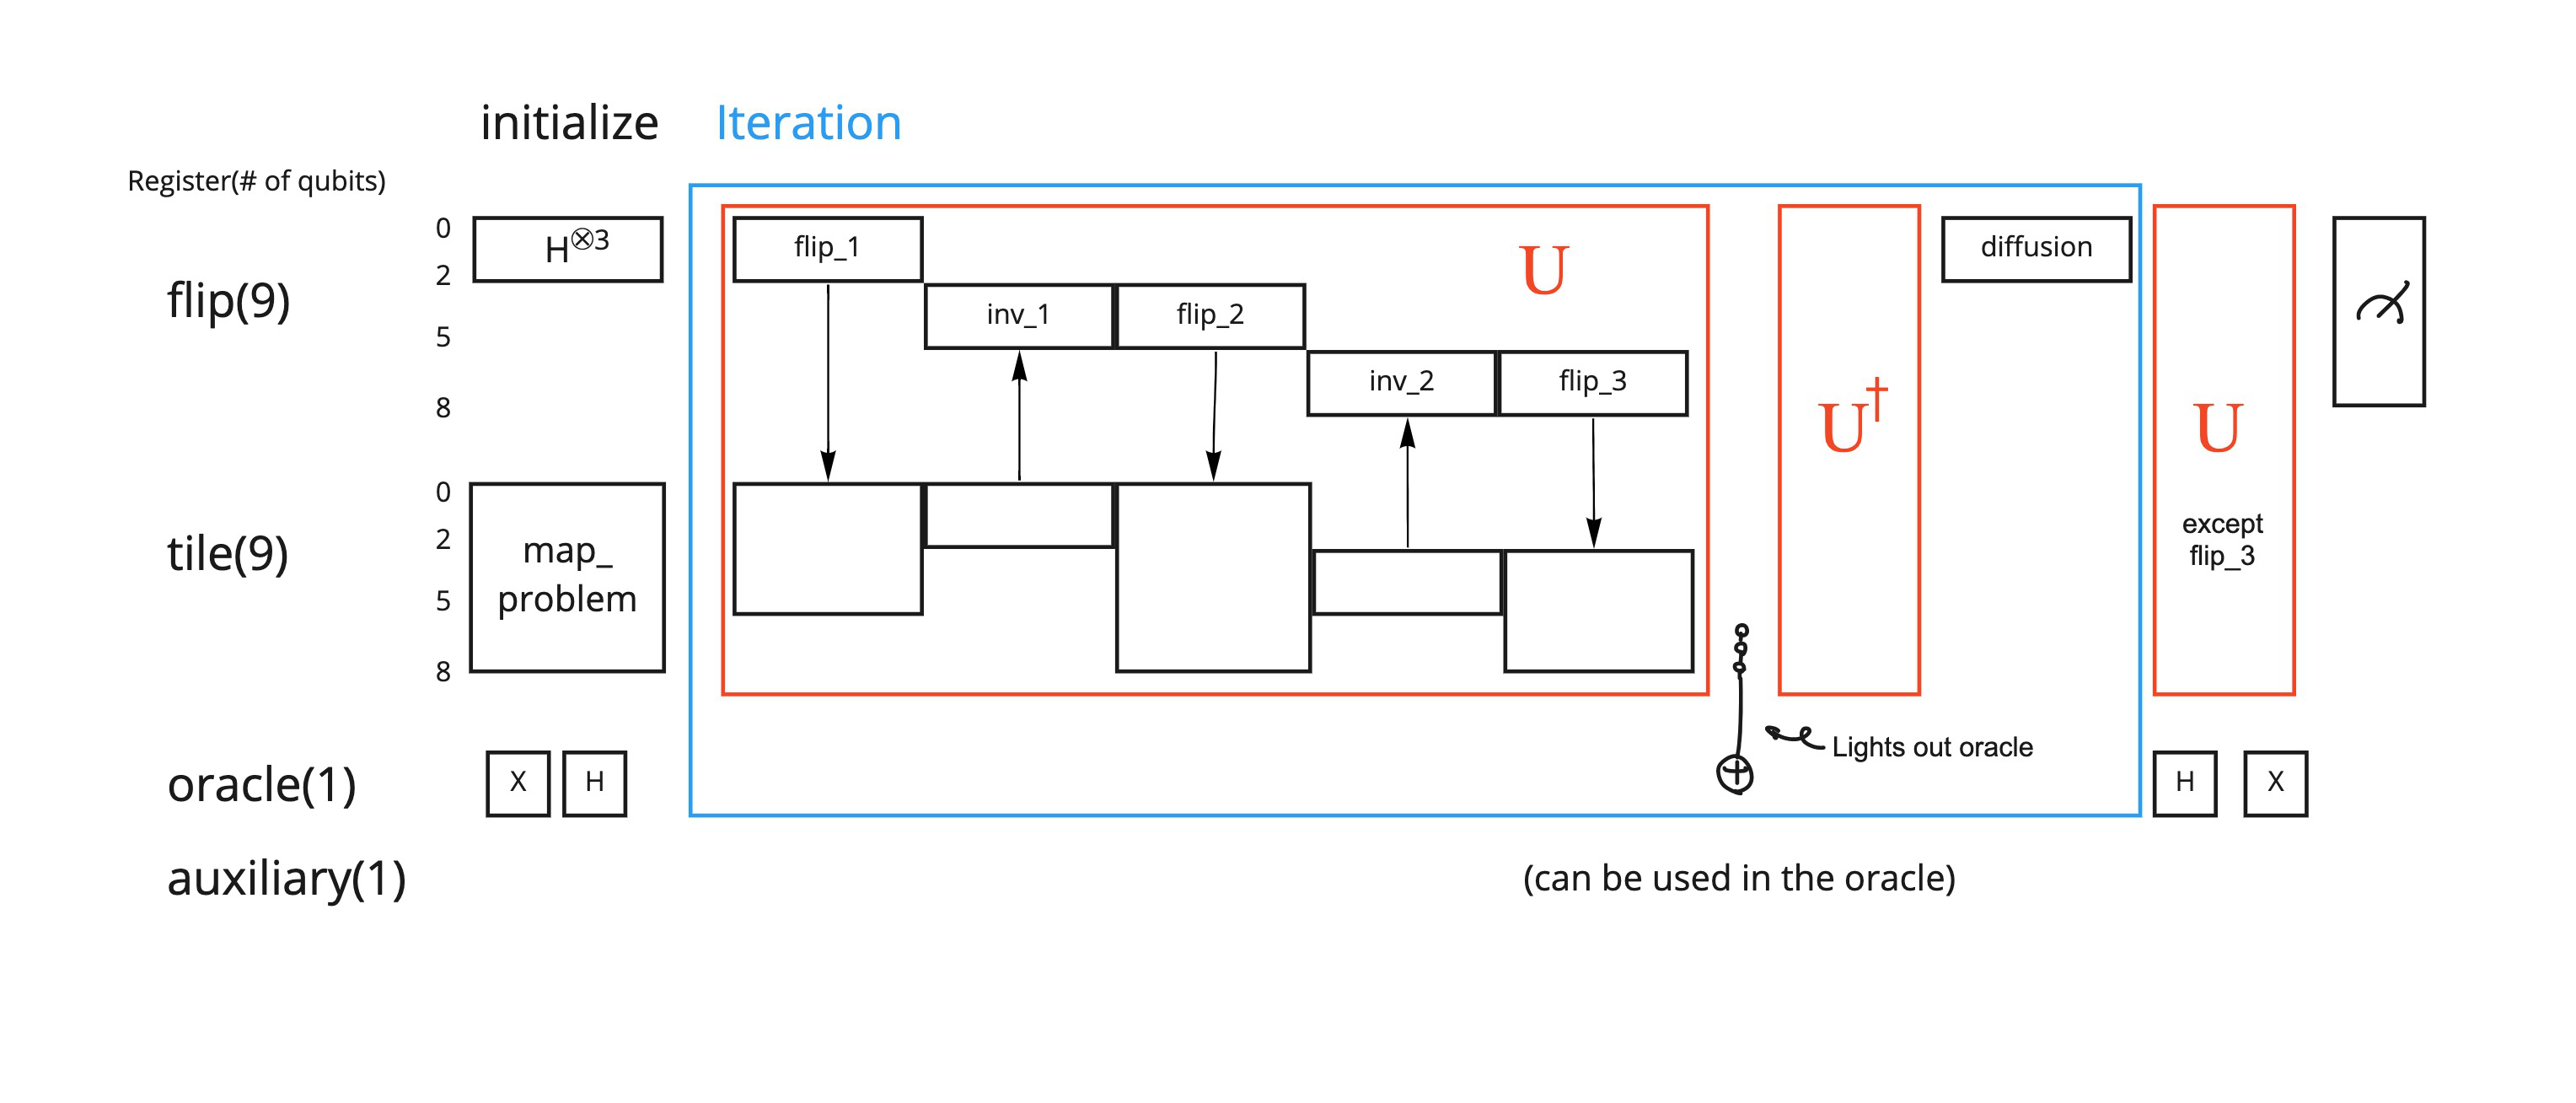

In [13]:
Image('lights_out_optimal_circuit.jpg')

In [14]:
tile = QuantumRegister(9)
flip = QuantumRegister(9)
oracle = QuantumRegister(1)
auxiliary = QuantumRegister(1)
result = ClassicalRegister(9)
# 20 qubit
qc = QuantumCircuit(tile, flip, oracle, auxiliary, result)

In the answer already shown, the `flip` function simply entered the solution candidates. Here, the solution is obtained by interacting the solution space(`flip`) and the board(`tile`) with the 3 bits of the top row of the solution candidate as input.

* The `flip_1` function inputs the candidates of the solusion(only the top line, 3-bit) to the board(1st and 2nd lines).

Then the first line of the `tile` register shows the lights which must be erased by remaining 6 bits of the solution.

* the `inv_1` function is a controlled operation from the tile function to the flip function, as opposed to the flip function. The light that could not be turned off in the first line after `flip_1` can be turned off by pressing the button directly below in the second line. Therefore, the state of the light on the first line left in `tile` is directly mapped to the solution on the second line.

* `flip_2`(`flip_3`) function press the button based on the solution on the 2nd (3rd) line determined by `inv_1` and `inv_2`, respectively.

* Similar to `inv_1`, the `inv_2` function determines the solution on the third line.

* `lights_out_oracle` is an oracle that marks the solution if all the lights are turned off after entering the solution candidates. In this answer, you can check if all the lights are off by just checking if the lights in the bottom row are off. This is because `inv_1` and `inv_2` turn off the lights in the top two lines, no matter what the top row of the solution candidate.

Since only the 3 bits of the top row of the solution are prepared as superpositions, the space searched by Grover's algorithm is $2^3$. Note that the `diffusion` function(inversion about averate) only needs to be performed on the 0th, 1st, and 2nd qubits of the `flip` register that stores the top row of the solution candidates. 

In [15]:
# Initialize
def initialize_smart(l,qc,tile):
    map_board(l, qc, tile)
    qc.h(flip[:3])
    qc.x(oracle[0])
    qc.h(oracle[0])

def flip_1(qc,flip,tile):
    # push 0
    qc.cx(flip[0], tile[0])
    qc.cx(flip[0], tile[1])
    qc.cx(flip[0], tile[3])
    # push 1
    qc.cx(flip[1], tile[0])
    qc.cx(flip[1], tile[1])
    qc.cx(flip[1], tile[2])
    qc.cx(flip[1], tile[4])
    # push 2
    qc.cx(flip[2], tile[1])
    qc.cx(flip[2], tile[2])
    qc.cx(flip[2], tile[5]) 
    
def inv_1(qc,flip,tile):
    # copy 0,1,2
    qc.cx(tile[0], flip[3])
    qc.cx(tile[1], flip[4])
    qc.cx(tile[2], flip[5])
    
def flip_2(qc,flip,tile):
    # apply flip[3,4,5]
    qc.cx(flip[3], tile[0])
    qc.cx(flip[3], tile[3])
    qc.cx(flip[3], tile[4])
    qc.cx(flip[3], tile[6])
    qc.cx(flip[4], tile[1])
    qc.cx(flip[4], tile[3])
    qc.cx(flip[4], tile[4])
    qc.cx(flip[4], tile[5])
    qc.cx(flip[4], tile[7])
    qc.cx(flip[5], tile[2])
    qc.cx(flip[5], tile[4])
    qc.cx(flip[5], tile[5])
    qc.cx(flip[5], tile[8])
    
def inv_2(qc,flip,tile1):
    # copy 3,4,5
    qc.cx(tile[3], flip[6])
    qc.cx(tile[4], flip[7])
    qc.cx(tile[5], flip[8])
    
def flip_3(qc,flip,tile):
    qc.cx(flip[6], tile[3])
    qc.cx(flip[6], tile[6])
    qc.cx(flip[6], tile[7])
    qc.cx(flip[7], tile[4])
    qc.cx(flip[7], tile[6])
    qc.cx(flip[7], tile[7])
    qc.cx(flip[7], tile[8])
    qc.cx(flip[8], tile[5])
    qc.cx(flip[8], tile[7])
    qc.cx(flip[8], tile[8])

def lights_out_oracle(qc,tile,oracle,auxiliary):
    qc.x(tile[6:9])
    qc.mct(tile[6:9], oracle[0], auxiliary, mode='basic')
    qc.x(tile[6:9])
    
def diffusion(qc,flip):
    qc.h(flip[:3])
    qc.x(flip[:3])
    qc.h(flip[2])
    qc.ccx(flip[0],flip[1],flip[2])
    qc.h(flip[2])
    qc.x(flip[:3])
    qc.h(flip[:3])

Let's execute the circuit by combining the functions created so far. The number of iteration is 2 since $\frac{\pi}{4} \sqrt{2^3} - \frac{1}{2} \risingdotseq 1.72$

In [16]:
initialize_smart(lights,qc,tile)

for i in range(2):
    flip_1(qc,flip,tile)
    inv_1(qc,flip,tile)
    flip_2(qc,flip,tile)
    inv_2(qc,flip,tile)
    flip_3(qc,flip,tile)
    
    lights_out_oracle(qc,tile,oracle,auxiliary)
    
    flip_3(qc,flip,tile)
    inv_2(qc,flip,tile)
    flip_2(qc,flip,tile)
    inv_1(qc,flip,tile)
    flip_1(qc,flip,tile)
    
    diffusion(qc,flip)
    
# Uncompute
qc.h(oracle[0])
qc.x(oracle[0])

# get the whole solution from the top row of the solution
# If you get a solution, you don't need to erase the board, so you don't need the flip_3 function.
flip_1(qc,flip,tile)
inv_1(qc,flip,tile)
flip_2(qc,flip,tile)
inv_2(qc,flip,tile)

# Measuremnt
qc.measure(flip,result)

# Make the Out put order the same as the input.
qc = qc.reverse_bits() 

In [17]:
# Unroll the circuit
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 

# obtain gates
gates=new_circuit.count_ops()
print(gates)

OrderedDict([('cx', 221), ('u3', 113), ('measure', 9)])


The cost of this circuit is just 2323! By limiting the search space of Grover's algorithm in this way, the cost can be significantly reduced.

In [18]:
%%time
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()

CPU times: user 61.9 ms, sys: 5.12 ms, total: 67 ms
Wall time: 5.79 s


In [19]:
score_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
final_score = score_sorted[0:40]
final_score

[('110010101', 7576),
 ('100101101', 72),
 ('010100000', 68),
 ('000011000', 60),
 ('001000101', 60),
 ('111001000', 55),
 ('011111101', 55),
 ('101110000', 54)]

You got the answer. You have been able to dramatically reduce costs!(30449→2323)